In [46]:
# Import important packages
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

import joblib
import os
import yaml
from IPython.display import display

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


# folder to load config file
CONFIG_PATH = "./config/"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config


config = load_config("my-config.yaml")


# load data
data = pd.read_csv(os.path.join(config["data_directory"], config["data_name"]))

In [25]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [26]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(0)

In [27]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

string_columns = list(data.dtypes[data.dtypes == 'object'].index)

for col in string_columns:
    data[col] = data[col].str.lower().str.replace(' ', '_')

In [28]:
data.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


In [29]:
data.churn = (data.churn == 'yes').astype(int)

In [30]:
df_train_full, df_test = train_test_split(data, test_size=config["test_size"], random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)


In [31]:
y_train = df_train.churn.values
y_val = df_val.churn.values

In [32]:
del df_train['churn']
del df_val['churn']

# Exploratory data analysis

In [33]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

In [34]:
global_mean = df_train_full.churn.mean()
round(global_mean, 3)

0.27

In [35]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [36]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

#  Feature importance

Knowing how other variables affect the target variable, churn, is the key to understanding the data and building a good model. This process is called feature importance analysis, and it’s often done as a part of exploratory data analysis to figure out which variables will be useful for the model. It also gives us additional insights about the dataset and helps answer questions like “What makes customers churn?” and “What are the characteristics of people who churn?”

In [37]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.277
gender == male:   0.263


In [39]:
female_mean / global_mean

1.0253955354648652

In [40]:
male_mean / global_mean

0.9749802969838747

Now let’s take a look at another variable: partner. It takes values of yes and no, so there are two groups of customers: the ones for which partner == 'yes' and the ones for which partner == 'no'.

In [38]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print('partner == yes:', round(partner_yes, 3))

partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print('partner == no :', round(partner_no, 3))

partner == yes: 0.205
partner == no : 0.33


In [41]:
partner_yes / global_mean

0.7594724924338315

In [42]:
partner_no / global_mean

1.2216593879412643

In [43]:
df_group = df_train_full.groupby(by='gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean
df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [45]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


This way, just by looking at the differences and the risks, we can identify the most discriminative features: the features that are helpful for detecting churn. Thus, we expect that these features will be useful for our future models.

# MUTUAL INFORMATION

The kinds of differences we just explored are useful for our analysis and important for understanding the data, but it’s hard to use them to say what the most important feature is and whether tech support is more useful than the type of contract.

Luckily, the metrics of importance can help us: we can measure the degree of dependency between a categorical variable and the target variable. If two variables are dependent, knowing the value of one variable gives us some information about another. On the other hand, if a variable is completely independent of the target variable, it’s not useful and can be safely removed from the dataset.

In our case, knowing that the customer has a month-to-month contract may indicate that this customer is more likely to churn than not.

In [47]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())
display(df_mi.tail())

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923


,MI
partner,0.009968
seniorcitizen,0.009410
multiplelines,0.000857
phoneservice,0.000229
gender,0.000117


# CORRELATION COEFFICIENT

Mutual information is a way to quantify the degree of dependency between two categorical variables, but it doesn’t work when one of the features is numerical, so we cannot apply it to the three numerical variables that we have.

We can, however, measure the dependency between a binary target variable and a numerical variable. We can pretend that the binary variable is numerical (containing only the numbers zero and one) and then use the classical methods from statistics to check for any dependency between these variables.

One such method is the correlation coefficient (sometimes referred as Pearson’s correlation coefficient). It is a value from –1 to 1:

Positive correlation means that when one variable goes up, the other variable tends to go up as well. In the case of a binary target, when the values of the variable are high, we see ones more often than zeros. But when the values of the variable are low, zeros become more frequent than ones.

Zero correlation means no relationship between two variables: they are completely independent.

Negative correlation occurs when one variable goes up and the other goes down. In the binary case, if the values are high, we see more zeros than ones in the target variable. When the values are low, we see more ones.



In [48]:
df_train_full[numerical].corrwith(df_train_full.churn).to_frame('correlation')

,correlation
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [49]:
df_train_full.groupby(by='churn')[numerical].mean()

,tenure,monthlycharges,totalcharges
churn,,,
0,37.531972,61.176477,2548.021627
1,18.070348,74.521203,1545.689415


# Feature engineering

In [50]:
from sklearn.feature_extraction import DictVectorizer

In [51]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [56]:
train_dict[0]

{'gender': 'male',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 71,
 'monthlycharges': 86.1,
 'totalcharges': 6045.9}

# One-hot encoding for categorical variables
As we already know from the first chapter, we cannot just take a categorical variable and put it into a machine learning model. The models can deal only with numbers in matrices. So, we need to convert our categorical data into a matrix form, or encode.

One such encoding technique is one-hot encoding. We already saw this encoding technique in the previous chapter, when creating features for the make of a car and other categorical variables. There, we mentioned it only briefly and used it in a very simple way. In this chapter, we will spend more time understanding and using it.

If a variable contract has possible values (monthly, yearly, and two-year), we can represent a customer with the yearly contract as (0, 1, 0). In this case, the yearly value is active, or hot, so it gets 1, whereas the remaining values are not active, or cold, so they are 0.

In [57]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [58]:
X_train = dv.transform(train_dict)
X_train.shape

(3774, 45)

In [61]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

# Machine learning for classification
# Training logistic regression

In [67]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [63]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [64]:
model.predict_proba(X_val)

array([[0.76508784, 0.23491216],
       [0.73113015, 0.26886985],
       [0.68054704, 0.31945296],
       ...,
       [0.94274614, 0.05725386],
       [0.38476895, 0.61523105],
       [0.93872763, 0.06127237]])

In [65]:
y_pred = model.predict_proba(X_val)[:, 1]

In [69]:
churn = y_pred > 0.5
(y_val == churn).mean()

0.8016129032258065

# Model interpretation

In [68]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


In [70]:
subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'tenure', 'totalcharges'], dtype=object)

In [71]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [72]:
dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': 0.91,
 'contract=one_year': -0.144,
 'contract=two_year': -1.404,
 'tenure': -0.097,
 'totalcharges': 0.001}

In [73]:
val_dict_small = df_val[subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

In [74]:
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

There are five features. As expected, we have tenure and totalcharges, and because they are numeric, their names are not changed.

As for the contract variable, it’s categorical, so DictVectorizer applies the one-hot encoding scheme to convert it to numbers. contract has three distinct values: month-to-month, one year, and two years. Thus, one-hot encoding scheme creates three new features: contract=month-to-month, contract=one_year, and contract= two_years.

# Using the model

In [75]:
customer = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'no',
    'dependents': 'no',
    'tenure': 41,
    'phoneservice': 'yes',
    'multiplelines': 'no',
    'internetservice': 'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year',
    'paperlessbilling': 'yes',
    'paymentmethod': 'bank_transfer_(automatic)',
    'monthlycharges': 79.85,
    'totalcharges': 3320.75,
}

In [76]:
X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.07332111084949638

In [77]:
print(list(X_test[0]))


[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 79.85, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 41.0, 3320.75]


In [78]:
customer = {
    'gender': 'female',
    'seniorcitizen': 1,
    'partner': 'no',
    'dependents': 'no',
    'phoneservice': 'yes',
    'multiplelines': 'yes',
    'internetservice': 'fiber_optic',
    'onlinesecurity': 'no',
    'onlinebackup': 'no',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'yes',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 85.7,
    'totalcharges': 85.7
}

In [79]:
X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.8321656556055403

# Accuracy

In [80]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8016129032258065

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

In [82]:
thresholds = np.linspace(0, 1, 11)


In [83]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


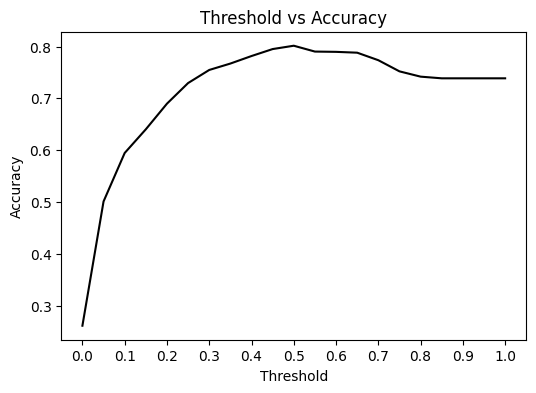

In [84]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [85]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

# Confusion table

In [86]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [87]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1202,  172],
       [ 197,  289]])

# K-fold cross-validation

In [88]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [92]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [90]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [93]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [94]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.842, 0.844, 0.822, 0.845,
       0.861])

In [95]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


# Tuning the parameter C

In [96]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [97]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.008
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


In [98]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858
